In [ ]:
#import packages
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as pn
import statistics as st
import math
pn.options.figure_size = (6,4)

def sort_factors(X_norm_log: np.ndarray, cell_score_matrix: np.ndarray, gene_loading_matrix: np.ndarray, plot_path : str, method : str = "explained_variance"):

    n_cells, _ = cell_score_matrix.shape

    n_factors, n_genes = gene_loading_matrix.shape

    # defined as variance of each selected gene divided by total variance
    if method == "explained_variance":

        # first, select top genes for each factor
        top_genes = select_top_genes(gene_loading_matrix)

        # calculate variance of each gene in cell x gene matrix
        gene_variance = [X_norm_log[:,x].var() for x in range(n_genes)]
        total_variance = sum(gene_variance)

        # divide sum of genes' variance by total to get explained_variance for each factor
        explained_variance = []

        for curr_factor in range(n_factors):
            explained_variance.append( sum([gene_variance[curr_gene] for curr_gene in top_genes[curr_factor]]) / total_variance)

        # if a plot path is provided, plot the factors' explained variance
        if plot_path:
            plot = (pn.ggplot()
                    + pn.aes(x = list(range(n_factors)), y = explained_variance)
                    + pn.xlab("Factor")
                    + pn.ylab("Explained Variance")
                    + pn.geom_point()
                    + pn.theme_bw())
            
            plot.save(f"{plot_path}/factors_explained_variance.pdf", dpi = 250, verbose = False)

        # sort by explained variance, return indices of sorted factors by explained variance
        sort_index = [factor for factor, _ in sorted(enumerate(explained_variance), key = lambda x: x[1], reverse = True)]


    # defined as sum of highly_variable_genes(cell_ranger) dispersions of selected genes
    elif method == "gene_dispersions":

        # first, select top genes for each factor
        top_genes = select_top_genes(gene_loading_matrix)

        # perform highly_variable_genes
        # the higher the 'dispersion' value, the more variation (according to "highly_variable" tag, backed up by variance)
        dummy_adata = sc.AnnData(X_norm_log)
        sc.pp.highly_variable_genes(dummy_adata, flavor = 'cell_ranger')

        # sum all selected genes for each factor
        sum_disp = []

        for curr_factor in range(n_factors):
            sum_disp.append(sum([dummy_adata.var["dispersions_norm"][curr_gene] for curr_gene in top_genes[curr_factor]]))

        # if a plot path is provided, plot the factors' explained variance
        if plot_path:
            plot = (pn.ggplot()
                    + pn.aes(x = list(range(n_factors)), y = sum_disp)
                    + pn.xlab("Factor")
                    + pn.ylab("Sum of Normalized Gene Dispersions")
                    + pn.geom_point()
                    + pn.theme_bw())
            
            plot.save(f"{plot_path}/factors_gene_dispersions.pdf", dpi = 250, verbose = False)

        # sort factors by their sum_disp
        sort_index = [factor for factor, _ in sorted(enumerate(sum_disp), key = lambda x: x[1], reverse = True)]


    # defined as highly_variable_genes(cell_ranger) dispersions of factors
    elif method == "factor_dispersions":

        # perform highly_variable_genes
        # the higher the 'dispersion' value, the more variation
        dummy_adata = sc.AnnData(cell_score_matrix)
        sc.pp.highly_variable_genes(dummy_adata, flavor = 'cell_ranger')

        factor_dispersions = dummy_adata.var["dispersions_norm"].values 

        # if a plot path is provided, plot the factors' explained variance
        if plot_path:
            plot = (pn.ggplot()
                    + pn.aes(x = list(range(n_factors)), y = factor_dispersions)
                    + pn.xlab("Factor")
                    + pn.ylab("Normalized Dispersion")
                    + pn.geom_point()
                    + pn.theme_bw())
            
            plot.save(f"{plot_path}/factors_factor_dispersions.pdf", dpi = 250, verbose = False)

        # sort factors by their sum_disp
        sort_index = [factor for factor, _ in sorted(enumerate(factor_dispersions), key = lambda x: x[1], reverse = True)]

    else:
        raise ValueError("Invalid method - select 'explained_variance', 'gene_dispersions', or 'factor_dispersions'")

    return sort_index


def select_top_genes(gene_loading_matrix: np.ndarray):

    n_factors = len(gene_loading_matrix)
    top_genes = []

    for curr_factor in range(n_factors):

        curr_loadings = gene_loading_matrix[curr_factor]

        curr_cutoff = st.mean(curr_loadings) + 2 * st.stdev(curr_loadings)

        curr_top_genes = [idx for idx, value in enumerate(curr_loadings) if value > curr_cutoff]

        top_genes.append(curr_top_genes)
    
    return top_genes

In [ ]:
plot_path = "."

# adata = sc.read_h5ad("../../new_annData.h5ad")

adata = sc.read_h5ad("../../clean_myeloid.h5ad")

cell_scores = pd.read_csv("../../milo_cell_scores.csv", index_col = False, header = None).to_numpy()

gene_loadings = pd.read_csv("../../milo_gene_loadings.csv", index_col = False, header = None).to_numpy()

# factor_list = sort_factors(adata.X.toarray(), adata.obsm["SPECTRA_cell_scores"], adata.uns["SPECTRA_factors"], plot_path)

factor_list = sort_factors(adata.layers["norm_log"], cell_scores, gene_loadings, plot_path, "factor_dispersions")

In [ ]:
import rpy2
import anndata2ri
import os

adata_milo = sc.AnnData(adata.layers['norm_log'].copy(), 
                        obs = adata.obs[['SampleID', 'Celltype_myeloid', 'condition']], 
                        var = adata.var)
adata_milo.obsm['X_pca'] = adata.obsm['X_pca']
adata_milo.obsm['X_tsne'] = adata.obsm['X_tsne']
adata_milo.obsm_keys

# anndata2ri interconverts AnnData and Single Cell Experiment objects
anndata2ri.activate()
%load_ext rpy2.ipython


In [ ]:
%%R

library(miloR)
library(igraph)

R[write to console]: Loading required package: edgeR

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:miloR’:

    graph


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




In [ ]:
%%R -i adata_milo
adata_milo

/home/clinic/.local/lib/python3.10/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 12786 4718 
metadata(0):
assays(1): X
rownames(12786): GNAI3 CDC45 ... MIR155HG IGHV5-9
rowData names(0):
colnames(4718): 120703424032052000 120703436053422000 ...
  232261695269612011 239407446735798011
colData names(3): SampleID Celltype_myeloid condition
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):


In [ ]:
%%R 
myeloid_milo <- Milo(adata_milo)
myeloid_milo

class: Milo 
dim: 12786 4718 
metadata(0):
assays(1): X
rownames(12786): GNAI3 CDC45 ... MIR155HG IGHV5-9
rowData names(0):
colnames(4718): 120703424032052000 120703436053422000 ...
  232261695269612011 239407446735798011
colData names(3): SampleID Celltype_myeloid condition
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [ ]:
%%R 
myeloid_milo <- buildGraph(myeloid_milo, k=30, d=50, reduced.dim = "PCA")

R[write to console]: Constructing kNN graph with k:30



In [ ]:
design_df = adata_milo.obs[["condition", "SampleID"]].copy()
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['SampleID']
design_df

,condition,SampleID
SampleID,,
2_DT_1_CD45_minus,DT,2_DT_1_CD45_minus
2_DT_1_CD45plus,DT,2_DT_1_CD45plus
2_DT_2_CD45minus,DT,2_DT_2_CD45minus
2_DT_2_CD45plus,DT,2_DT_2_CD45plus
2_DT_3_CD45_minus,DT,2_DT_3_CD45_minus
2_DT_3_CD45plus,DT,2_DT_3_CD45plus
2_ctl_1_CD45minus,CTRL,2_ctl_1_CD45minus
2_ctl_1_CD45plus,CTRL,2_ctl_1_CD45plus
2_ctl_2_CD45plus,CTRL,2_ctl_2_CD45plus


In [ ]:
%%R -i design_df -o DA_results_myeloid
## Define neighbourhoods
myeloid_milo <- makeNhoods(myeloid_milo, prop = 0.1, k = 30, d=50, refined = TRUE, reduced_dims = "PCA")

## Count cells in neighbourhoods
myeloid_milo <- countCells(myeloid_milo, meta.data = data.frame(colData(myeloid_milo)), sample="SampleID")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
myeloid_milo <- calcNhoodDistance(myeloid_milo, d=50, reduced.dim = "PCA")

## Test for differential abundance
DA_results_myeloid <- testNhoods(myeloid_milo, design = ~condition, design.df = design_df)

R[write to console]: Checking valid object

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withk-distance weighting



Text(0, 0.5, '- log10(Spatial FDR)')

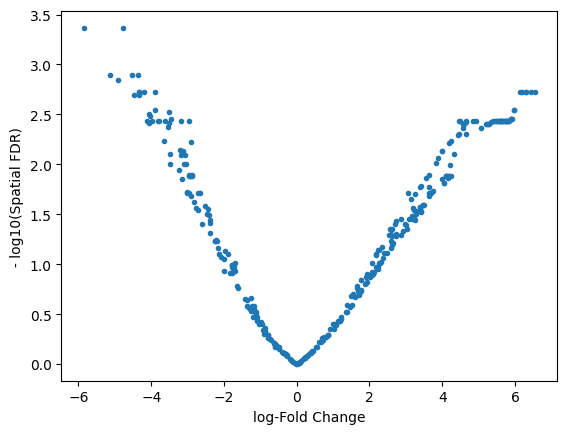

In [ ]:
plt.plot(DA_results_myeloid.logFC, -np.log10(DA_results_myeloid.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

In [ ]:
%%R
myeloid_milo <- buildNhoodGraph(myeloid_milo)

In [ ]:
%%R -w 600 -h 450
library(ggplot2)
alpha_val = 1
for (j in c('SpatialFDR', 'FDR', 'PValue', 'logFC')){
    p1 <- plotNhoodGraphDA(myeloid_milo, DA_results_myeloid, res_column = j, alpha=alpha_val, layout="TSNE", 
                           size_range = c(2, 8), node_stroke =.8)
    ggsave(paste0(outbase, 'milor_R_myeloid_', j, '.pdf'), p1, dpi = 200)
}

Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image


In [ ]:
%%R 
DA_results_myeloid <- annotateNhoods(myeloid_milo, DA_results_myeloid, coldata_col = "Celltype_myeloid")
head(DA_results_myeloid)

       logFC   logCPM          F       PValue         FDR Nhood  SpatialFDR
1 -1.1053214 12.56986  1.1488802 0.2838665043 0.366177238     1 0.358909412
2 -0.3666915 12.60812  0.1236583 0.7251238861 0.783856662     2 0.778505770
3  5.5503935 12.56809 11.6714543 0.0006427732 0.004012508     3 0.003713272
4  1.7017818 12.31219  2.1313237 0.1444166596 0.207076780     4 0.201011387
5  3.0225321 12.68795  5.2147572 0.0224628342 0.046396449     5 0.044297231
6  4.5807350 12.99598 11.0526005 0.0008958521 0.004258365     6 0.003933443
     Celltype_myeloid Celltype_myeloid_fraction
1     C1QA Macrophage                 1.0000000
2     C1QA Macrophage                 0.9814815
3      CSF3R Monocyte                 1.0000000
4     ARG1 Macrophage                 0.5789474
5            Monocyte                 0.9000000
6 Alveolar Macrophage                 1.0000000


In [ ]:
%%R -o DA_results_myeloid
DA_results_myeloid$Myeloid_Celltypes <- ifelse(DA_results_myeloid$Celltype_myeloid_fraction < 0.8, "Mixed", DA_results_myeloid$Celltype_myeloid)
head(DA_results_myeloid)

       logFC   logCPM          F       PValue         FDR Nhood  SpatialFDR
1 -1.1053214 12.56986  1.1488802 0.2838665043 0.366177238     1 0.358909412
2 -0.3666915 12.60812  0.1236583 0.7251238861 0.783856662     2 0.778505770
3  5.5503935 12.56809 11.6714543 0.0006427732 0.004012508     3 0.003713272
4  1.7017818 12.31219  2.1313237 0.1444166596 0.207076780     4 0.201011387
5  3.0225321 12.68795  5.2147572 0.0224628342 0.046396449     5 0.044297231
6  4.5807350 12.99598 11.0526005 0.0008958521 0.004258365     6 0.003933443
     Celltype_myeloid Celltype_myeloid_fraction   Myeloid_Celltypes
1     C1QA Macrophage                 1.0000000     C1QA Macrophage
2     C1QA Macrophage                 0.9814815     C1QA Macrophage
3      CSF3R Monocyte                 1.0000000      CSF3R Monocyte
4     ARG1 Macrophage                 0.5789474               Mixed
5            Monocyte                 0.9000000            Monocyte
6 Alveolar Macrophage                 1.0000000 Alveolar Mac

R[write to console]: Converting group.by to factor...



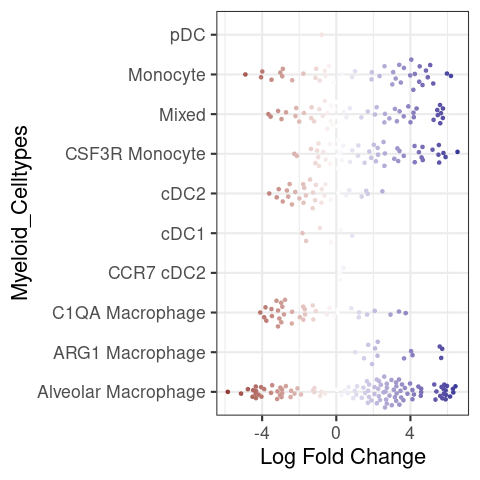

In [ ]:
%%R
plotDAbeeswarm(DA_results_myeloid, group.by = "Myeloid_Celltypes", alpha = 1)

/tmp/ipykernel_15147/3189959936.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(scalarmappaple)
/tmp/ipykernel_15147/3189959936.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
/tmp/ipykernel_15147/3189959936.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(scalarmappaple)
/tmp/ipykernel_15147/3189959936.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator

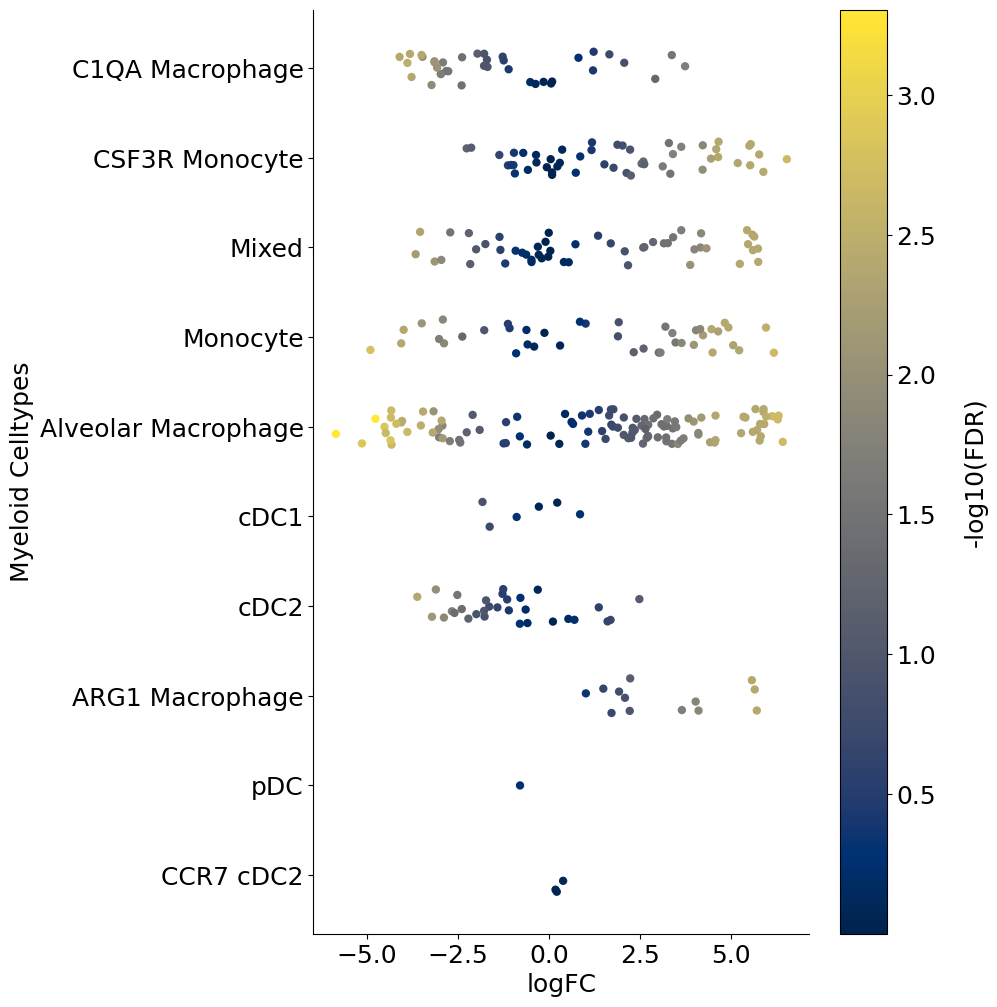

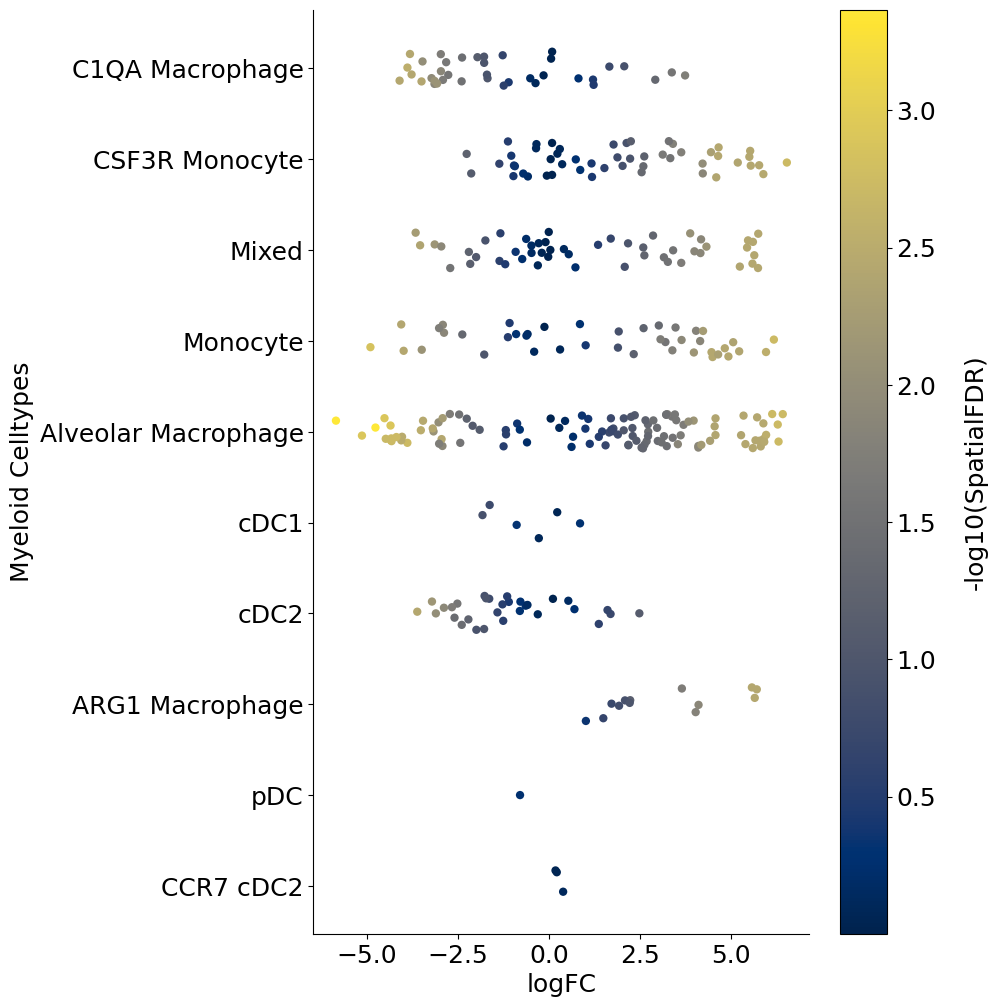

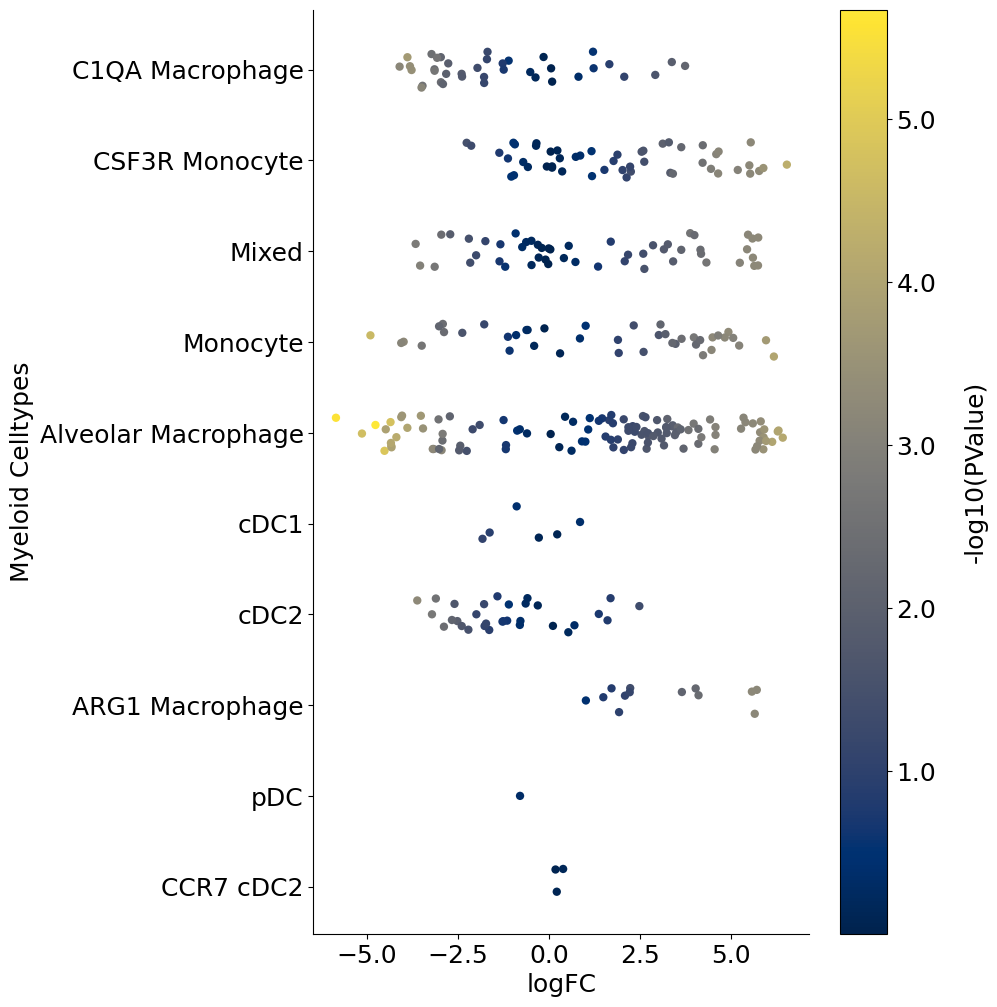

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

for j, item in enumerate(['FDR', 'SpatialFDR', 'PValue']):
    fig = plt.figure(figsize = (8, 12))
    DA_results_myeloid['log_' + item] = -np.log10(DA_results_myeloid[item])
    ax = fig.add_subplot(1, 1, 1)
    plot = sns.stripplot(x='logFC', y='Myeloid_Celltypes', hue='log_' + item, data=DA_results_myeloid, size = 6, 
              palette='cividis', 
              jitter=0.2, edgecolor='none', ax = ax)
    plot.get_legend().set_visible(False)
    #ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
    #ax.set_yticklabels(ax.get_yticks(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylabel('Myeloid Celltypes', fontsize = 18)
    ax.set_xlabel('logFC', fontsize = 18)
    sns.despine()


    # Drawing the side color bar
    normalize = mcolors.Normalize(vmin=DA_results_myeloid['log_' + item].min(), 
                              vmax=DA_results_myeloid['log_' + item].max())
    colormap = cm.cividis

    for n in DA_results_myeloid['log_' + item]:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(DA_results_myeloid['log_' + item])
    cbar = fig.colorbar(scalarmappaple)
    cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
    cbar.ax.set_ylabel('-log10(' + item + ')',  labelpad = 20, rotation=90, fontsize = 18)
    ax.grid(False)
    fig.savefig(outbase + 'milor_myeloid_swarmplot_colored_by_log_' + item + '.pdf', dpi = 300, 
                bbox_inches = 'tight')